r/ApplyingToCollege is a subreddit for high school students to discuss college admissions. Every year, once admissions decisions are released, there are megathreads set up for students to discuss whether or not they got in and what their grades, test scores, extracurriculars, etc. were like so other students can gauge how competitive admissions were for that college in that year. In this notebook, I scrape all posts from the megathreads for UC Davis from the last 3 years; naively extract SAT scores, unweighted GPAs, and admissions statuses from these posts; and use k-nearest neighbors to predict a student's admission status given their SAT score and unweighted GPA.

Disclaimer: My code attempts a very simple approach of taking two parameters to predict admission status and fails to take into account many other factors in the college admissions process such as extracurriculars, essays, family income, etc. This is definitely something I would like to improve upon in the future.

In [ ]:
#necessary libraries
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'

In [ ]:
extracted_comments = []
def scrape():
    for url in urls:
        request = urllib.request.Request(url,headers={'User-Agent': user_agent})
        html = urllib.request.urlopen(request).read()           
        soup = BeautifulSoup(html,'html.parser')
        comment_area = soup.find('div',attrs={'class':'commentarea'})
        comments = comment_area.find_all('div', attrs={'class':'entry unvoted'})
        for comment in comments: 
            if comment.find('form'):
                comment_text = comment.find('div',attrs={'class':'md'}).text
                extracted_comments.append(comment_text)

For this notebook, I use megathreads for UC Davis as this was the school that gave me the best balance of clean and a large amount of data. Some other popular schools from r/ApplyingToCollege are listed below for easy substitution.

In [ ]:
#reddit pages for most popular schools
urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/aync6m/official_2019_university_of_california_davis/?limit=500", "https://old.reddit.com/r/ApplyingToCollege/comments/83b3cn/uc_davis_stats_thread/?limit=500",
        "https://old.reddit.com/r/ApplyingToCollege/comments/835n7c/uc_davis_decision_megathread/"] #UC Davis
#ucla urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b3tyrj/official_2019_university_of_california_los/?limit=500"]
#usc urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b3eemc/official_2019_university_of_southern_california/?limit=500"]
#mit urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/84gzgb/mit_statsdecisions_separate_megathread/?limit=500"]
#caltech urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/ayztkb/official_2019_california_institute_of_technology/?sort=new"]
#ucb urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5mcup/official_2019_university_of_california_berkeley/?limit=500"]
#brown urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5uqbs/official_2019_brown_university_megathread/?sort=new"]
#upenn urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5uqki/official_2019_university_of_pennsylvania/?sort=new"]
#columbia urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5uq26/official_2019_columbia_university_megathread/?sort=new"]
#cornell urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5ur0q/official_2019_cornell_university_megathread/?sort=new"]
#yale urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5up4c/official_2019_yale_university_megathread/?sort=new"]
#harvard urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b5uovg/official_2019_harvard_university_megathread/?sort=new"]
#uchicago urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b09yc2/official_2019_university_of_chicago_megathread/?sort=new"]
#stanford urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b6dkt0/official_2019_stanford_university_megathread/?sort=new"]
#georgiatech urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/ayzu23/offical_2019_georgia_institute_of_technology/?sort=new"]
#jhu urls = ["https://old.reddit.com/r/ApplyingToCollege/comments/b0fp4u/official_2019_johns_hopkins_university_megathread/?sort=new"]

In [ ]:
scrape() #scrape data from specified urls

In [ ]:
statuses = []
test_scores = []
gpas = []

In [ ]:
sat_conversion_array = [1080, 1110, 1140, 1180, 1210, 1240, 1280, 1310, 1340, 1370, 1400, 1430, 1460, 1500, 1540, 1590] #used to convert from act to sat, uses the official 2018 act/sat concordance table

Below you can begin to see how this is a very naive approach. I basically assume the first occurence of all numbers with decimals from 3.0 to 4.0 to be unweighted GPA's (although they may actually be weighted GPA's or better yet just a number that has literally any other significance), numbers from 21 to 36 to be ACT scores, numbers ending in 0 from 1100 to 1600 to be SAT scores, and the first mention of one of the words 'accepted', 'rejected', 'denied' or 'waitlisted' to be the admissions status.

However, due to the nature of these comments in the sense that they are typically formatted the same way, I am able to get away with a lot of these simplifications and recieve reasonable results. I think it may be possible to apply some sort of NLP model to get more accurate results, but that is beyond the scope of my knowledge at this point. 

In [ ]:
#clean up comments to extract relevant info
for i in range(len(extracted_comments)):
  comment = extracted_comments[i]
  comment = comment.lower()

  accepted = re.search('accepted', comment)
  rejected = re.search('rejected', comment)
  denied = re.search('denied', comment)
  waitlisted = re.search('waitlisted', comment)
  numeric_data = re.findall('\d*\.?\d+',comment) #all numbers in the comment

  gpa = 0
  test_score = 0
  status = ''

  for number in numeric_data:
    if float(number) in range(21, 36): #act score, assume scores are above 21
      test_score = sat_conversion_array[int(number) - 21]
    elif float(number) in range(1100, 1600, 10): #sat score, assume scores are above 1100
      test_score = int(number)
    elif float(number) > 3 and float(number) <= 4 and '.' in str(number):
      gpa = float(number)

  if accepted and not rejected and not denied and not waitlisted:
    status = 'accepted'
  elif not accepted and (rejected or denied) and not waitlisted:
    status = 'rejected'
  elif not accepted and not rejected and not denied and waitlisted:
    status = 'waitlisted'
  
  if gpa != 0 and test_score != 0 and status != '':
    statuses.append(status)
    test_scores.append(test_score)
    gpas.append(gpa)
  
#extracted_comments

['Accepted: Genetics and Genomics\nChinese-American Female, Out-of-State\n-GPA: 3.8 (UW)\nCurrently 5.3 (W), ~5.6 @ end of the year\nClass rank (5/321)\n-ACT: 33 (35 English, 34 Reading, 29 Math (rip), 32 Science, 11 Writing)\n-13 AP Classes\n-Decent amount of volunteer hours, several ECs, mediocre essays\n',
 'Accepted- Aerospace Engineering and Science \nGPA 4.0 weighted(19/203), 3.8~ unweighted\nSAT 1340\nEcs: DnD DM (yes I included this), Math competitions, NHS, Model UN, cross country ski team, gaming club, and fantasy writing\nOut of State white Male\n(probably got in because no one else in my state applied)\n',
 "Accepted.\n32 ACT\nweighted: 4.3\nunweighted: 3.9\n5's on APUSH, Euro, AP Environmental Science\nEC: nominated for USA national model UN team, debate captain of top 20 debate school nationally, captain of model un team (ranked top 10 globally), captain of mock trial, First place delegate at Harvard model UN, top 40 at nationals in public forum debate, top 10 debaters in

In [ ]:
data = {'Test Score': test_scores, 'GPA': gpas, 'Status' : statuses}

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data=data)
df = df.drop_duplicates(ignore_index=True) #get rid of duplicated entries

In [ ]:
df

,Test Score,GPA,Status
0,1430,3.80,accepted
1,1340,3.80,accepted
2,1430,3.90,accepted
3,1540,3.89,accepted
4,1360,3.98,accepted
...,...,...,...
156,1460,3.89,waitlisted
157,1410,3.79,rejected
158,1430,3.95,accepted
159,1460,3.88,waitlisted


First, I would like to create a scatterplot of the data to see if it has some resemblence of clustering that would allow for KNN to work well

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#get data from df in a way that allows us to create a scatterplot
df_by_status = df.sort_values(by='Status', ignore_index=True)

accepted = df_by_status.loc[df_by_status.Status=='accepted']
waitlisted = df_by_status.loc[df_by_status.Status=='waitlisted']
rejected = df_by_status.loc[df_by_status.Status=='rejected']

accepted_test_scores = accepted['Test Score'].tolist()
accepted_gpas = accepted['GPA'].tolist()

waitlisted_test_scores = waitlisted['Test Score'].tolist()
waitlisted_gpas = waitlisted['GPA'].tolist()

rejected_test_scores = rejected['Test Score'].tolist()
rejected_gpas = rejected['GPA'].tolist()

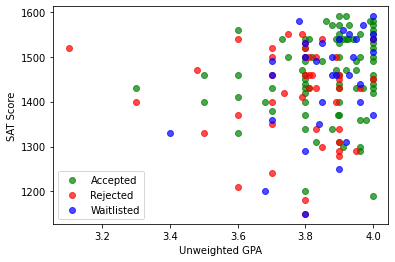

In [ ]:
  plt.scatter(accepted_gpas, accepted_test_scores, color='g', label='Accepted', alpha=0.7)
  plt.scatter(rejected_gpas, rejected_test_scores, color='r', label='Rejected', alpha=0.7)
  plt.scatter(waitlisted_gpas, waitlisted_test_scores, color='b', label='Waitlisted', alpha=0.7)
  plt.xlabel('Unweighted GPA')
  plt.ylabel('SAT Score')
  plt.legend()
  plt.show()

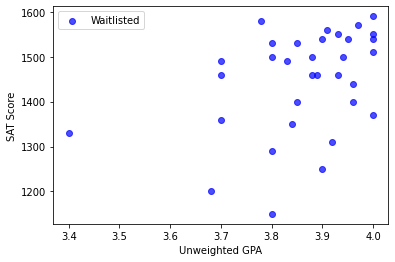

In [ ]:
plt.scatter(waitlisted_gpas, waitlisted_test_scores, color='b', label='Waitlisted', alpha=0.7)
plt.xlabel('Unweighted GPA')
plt.ylabel('SAT Score')
plt.legend()
plt.show()

As we can see above, the waitlisted values are seemingly scattered across the board randomly. This will likely throw off the accuracy of the model. After thinking about using this model practically, I figured that a user would rather see more accurate results displaying only a prediction of acceptance or rejection over less accurate results displaying a prediction of being waitlisted as well. In addition, we do not lose a significant amount of data since there weren't a great deal of waitlists.

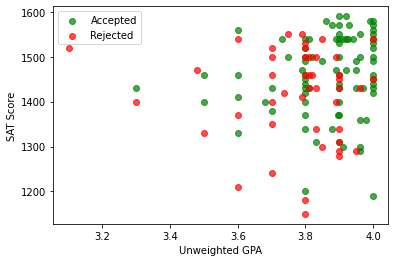

In [ ]:
  plt.scatter(accepted_gpas, accepted_test_scores, color='g', label='Accepted', alpha=0.7)
  plt.scatter(rejected_gpas, rejected_test_scores, color='r', label='Rejected', alpha=0.7)
  #plt.scatter(waitlisted_gpas, waitlisted_test_scores, color='b', label='Waitlisted', alpha=0.7)
  plt.xlabel('Unweighted GPA')
  plt.ylabel('SAT Score')
  plt.legend()
  plt.show()

In [ ]:
df['Status'] = df['Status'].replace(['accepted'], 1)
df['Status'] = df['Status'].replace(['rejected'], 0)
df = df[df.Status != 'waitlisted']
df.reset_index(drop=True, inplace=True)

In [ ]:
df

,Test Score,GPA,Status
0,1430,3.80,1
1,1340,3.80,1
2,1430,3.90,1
3,1540,3.89,1
4,1360,3.98,1
...,...,...,...
123,1540,3.91,1
124,1500,3.80,1
125,1410,3.79,0
126,1430,3.95,1


As we can see, the top right corner consists mostly of acceptances and and as gpa and SAT score decrease, we start to see more rejections. It is worth noting that there is not really a point where we can safely say that an applicant will very likely be rejected just by looking at the plot. This means that KNN will likely be more confident for acceptance than rejections.

It's now time to format the data for KNN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Test Score  128 non-null    int64  
 1   GPA         128 non-null    float64
 2   Status      128 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


In [ ]:
y_df = df.pop('Status')
y = y_df.astype('int')

In [ ]:
y = y.to_numpy()
X = df.to_numpy()

In [ ]:
from sklearn.model_selection import cross_val_score

Create KNN models for varying values of K and plot to find the best value. I got some help from: https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,60)
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy') #10 fold cross validation since we are working with a small dataset
  scores_list.append(scores.mean())

Text(0, 0.5, 'Accuracy')

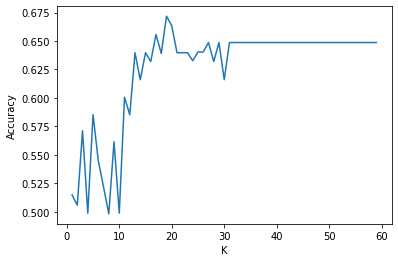

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_range, scores_list)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [ ]:
import numpy as np

print("max accuracy:", np.max(scores_list))
print("'best' K value in terms of accuracy:", str(np.argmax(scores_list) + 1))
test_value = 5
print("my test value's accuracy", scores_list[test_value + 1])
print("\nRandomly guessing everything as acceptances and rejections respectively")
y_df.value_counts(normalize=True) * 100

max accuracy: 0.6717948717948719
'best' K value in terms of accuracy: 19
my test value's accuracy 0.5217948717948719

Randomly guessing everything as acceptances and rejections respectively


1    64.84375
0    35.15625
Name: Status, dtype: float64

As we can see, our model is slightly better than randomly guessing at its maximum accuracy. However, it appears that our model will trade off correctly picking acceptences with the highest accuracy possible for picking rejections with higher accuracy as well if we allow k to be on the smaller end. Our acceptance accuracy will be lower than guessing everything as an acceptance, but our rejection accuracy will be much higher. We can play around with this number to see what works best. I ended up going with the following:

In [ ]:
k = 5

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
knn_final = KNeighborsClassifier(n_neighbors=k)
knn_final.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn_final.predict(X)
matrix = confusion_matrix(y, y_pred)
class_accuracy = matrix.diagonal()/matrix.sum(axis=1)
print("accuracy for rejections:", class_accuracy[0], "\naccuracy for acceptances:", class_accuracy[1])

accuracy for rejections: 0.5333333333333333 
accuracy for acceptances: 0.8192771084337349


In [ ]:
sat_score_for_prediction = 1450 #@param {type:"integer"}
gpa_for_prediction =  3.45#@param {type:"number"}

In [ ]:
prediction = knn_final.predict_proba([[sat_score_for_prediction, gpa_for_prediction]])
print(" based on an SAT score of", sat_score_for_prediction, "and an unweighted gpa of " + str(gpa_for_prediction) + ":\n")
print("", round(prediction[0][0] * 100,2), "% chance of rejection\n", round(prediction[0][1] * 100, 2), "% chance of acceptance\n")
print(" from", k, "votes (k = " + str(k) + ")")

 based on an SAT score of 1450 and an unweighted gpa of 3.45:

 40.0 % chance of rejection
 60.0 % chance of acceptance

 from 5 votes (k = 5)


Out of curiousity, I wanted to see how well our data would work with other classifiers from the scikit-learn library

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy') #10 fold cross validation since we are working with a small dataset
print(scores.mean())

0.6487179487179489


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy') #10 fold cross validation since we are working with a small dataset
print(scores.mean())

0.5455128205128205


In [ ]:
from sklearn import svm
model = svm.SVC()
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy') #10 fold cross validation since we are working with a small dataset
print(scores.mean())

0.6487179487179489


It appears that Logistic Regression and SVM provide a seemingly higher score than our KNN model. I'm going to take a deeper look into Logistic Regression (just because I am more familiar with it than I am with SVM)

In [ ]:
logreg = LogisticRegression(penalty='l2',C=0.1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logreg.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

As we can see, logistic regression is just picking everyone as an admit. Let's see if this is reasonable given the testing labels

In [ ]:
y_test

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

It appears not. Looking back at the plot for KNN, we can see that guessing all acceptances will give us the exact score that the model is giving us. Encouraging the model to also guess rejections will likely bring down the accuracy to a level similar to that of our KNN model. Therefore, I feel that the additional complexity presented by using Logistic Regression is not justifiable, especially for such a tiny dataset